In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import re
import matplotlib.pyplot as plt
import geopandas as gpd

In [2]:
df = pd.read_csv("/Users/xavi/Documents/Ironhack/Projects/Shark_project/attacks.csv", encoding="ISO-8859-1")

# LIMPIEZA GENERAL DE DATOS

Eliminamos espacios en blanco al principio y al final de los nombres de columnas

In [3]:
df = df.rename(columns=lambda x: x.strip())

In [4]:
df

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,...,Species,Investigator or Source,pdf,href formula,href,Case Number.1,Case Number.2,original order,Unnamed: 22,Unnamed: 23
0,2018.06.25,25-Jun-2018,2018.0,Boating,USA,California,"Oceanside, San Diego County",Paddling,Julie Wolfe,F,...,White shark,"R. Collier, GSAF",2018.06.25-Wolfe.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.25,2018.06.25,6303.0,NaN,NaN
1,2018.06.18,18-Jun-2018,2018.0,Unprovoked,USA,Georgia,"St. Simon Island, Glynn County",Standing,Adyson McNeely,F,...,NaN,"K.McMurray, TrackingSharks.com",2018.06.18-McNeely.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.18,2018.06.18,6302.0,NaN,NaN
2,2018.06.09,09-Jun-2018,2018.0,Invalid,USA,Hawaii,"Habush, Oahu",Surfing,John Denges,M,...,NaN,"K.McMurray, TrackingSharks.com",2018.06.09-Denges.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.09,2018.06.09,6301.0,NaN,NaN
3,2018.06.08,08-Jun-2018,2018.0,Unprovoked,AUSTRALIA,New South Wales,Arrawarra Headland,Surfing,male,M,...,2 m shark,"B. Myatt, GSAF",2018.06.08-Arrawarra.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.08,2018.06.08,6300.0,NaN,NaN
4,2018.06.04,04-Jun-2018,2018.0,Provoked,MEXICO,Colima,La Ticla,Free diving,Gustavo Ramos,M,...,"Tiger shark, 3m",A .Kipper,2018.06.04-Ramos.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.04,2018.06.04,6299.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25718,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25721,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Eliminamos las columnas que no aportan datos relevantes para nuestras cuestiones / hipotesis:

In [5]:
df.drop(labels=["Case Number", "original order", "Investigator or Source", "pdf", "href formula", "href", "Case Number.1", "Case Number.2", "Unnamed: 22", "Unnamed: 23"], axis=1, inplace=True)

Eliminamos filas con NaN en todas partes:

In [6]:
df.dropna(how="all", inplace=True)

## Limpieza de Fatal (Y/N)

Si aparece Fatal en "Injury", añadimos "Y" en "Fatal (Y/N).

In [7]:
df.Injury = df.Injury.fillna("")
df.loc[df["Injury"].str.contains("FATAL"), "Fatal (Y/N)"] = "Y"

Vamos a seguir limpiando Fatal (Y/N). Para ello, vamos a buscar si en Injury hay ciertas palabras que nos indiquen Y o N

In [8]:
death_pattern = "remains|Missing|Bones|Death|death|Fatal|fatal|mortem|killed|Killed|drowned|Drowned|drowning|drowing|Drowning|scavenging|corpse|scavenged|Body|body|bodies|Disappeared"
mask = df["Injury"].str.contains(death_pattern, regex=True)
df.loc[mask, "Fatal (Y/N)"] = "Y"

In [9]:
alive_pattern = "recovering|Minor|minor|Recovered|recovered|Cuts|Leg|leg|Survived|abrasions|Abrasion|Injury|injury|injured|injuries|Injuries|foot|Laceration|laceration|lacerations|laceraten|lacerated|bit|bitten|Bitten"
mask = mask = df["Injury"].str.contains(alive_pattern, regex=True)
df.loc[mask, "Fatal (Y/N)"] = "N"

## Limpieza de YEAR

In [10]:
df.Year.unique()

array([2018., 2017.,   nan, 2016., 2015., 2014., 2013., 2012., 2011.,
       2010., 2009., 2008., 2007., 2006., 2005., 2004., 2003., 2002.,
       2001., 2000., 1999., 1998., 1997., 1996., 1995., 1984., 1994.,
       1993., 1992., 1991., 1990., 1989., 1969., 1988., 1987., 1986.,
       1985., 1983., 1982., 1981., 1980., 1979., 1978., 1977., 1976.,
       1975., 1974., 1973., 1972., 1971., 1970., 1968., 1967., 1966.,
       1965., 1964., 1963., 1962., 1961., 1960., 1959., 1958., 1957.,
       1956., 1955., 1954., 1953., 1952., 1951., 1950., 1949., 1948.,
       1848., 1947., 1946., 1945., 1944., 1943., 1942., 1941., 1940.,
       1939., 1938., 1937., 1936., 1935., 1934., 1933., 1932., 1931.,
       1930., 1929., 1928., 1927., 1926., 1925., 1924., 1923., 1922.,
       1921., 1920., 1919., 1918., 1917., 1916., 1915., 1914., 1913.,
       1912., 1911., 1910., 1909., 1908., 1907., 1906., 1905., 1904.,
       1903., 1902., 1901., 1900., 1899., 1898., 1897., 1896., 1895.,
       1894., 1893.,

Reemplazamos valores Nan por 0:

In [11]:
df.Year = df.Year.fillna(0)

Hay muchos años con valor 0, vamos a ponerle un valor según Date. Les ponemos los 4 últimos dígitos de la columna Date:

In [12]:
df.loc[df["Year"]==0, "Year"] = df["Date"].str[-4:]


Reemplazamos valores no numéricos por 0:

In [13]:
df.Year.replace(to_replace="[^0-9]", regex=True, value=0 , inplace=True)


In [14]:
df.Year.unique()

array([2018.0, 2017.0, '2017', 2016.0, 2015.0, 2014.0, 2013.0, 2012.0,
       2011.0, 2010.0, 2009.0, 2008.0, 2007.0, 2006.0, 2005.0, 2004.0,
       2003.0, 2002.0, 2001.0, 2000.0, 1999.0, 1998.0, 1997.0, 1996.0,
       1995.0, 1984.0, 1994.0, 1993.0, 1992.0, 1991.0, 1990.0, 1989.0,
       1969.0, 1988.0, 1987.0, 1986.0, 1985.0, 1983.0, 1982.0, 1981.0,
       1980.0, 1979.0, 1978.0, 1977.0, 1976.0, 1975.0, 1974.0, 1973.0,
       1972.0, 1971.0, 1970.0, 1968.0, 1967.0, 1966.0, 1965.0, 1964.0,
       1963.0, 1962.0, 1961.0, 1960.0, 1959.0, 1958.0, 1957.0, 1956.0,
       1955.0, 1954.0, 1953.0, 1952.0, 1951.0, 1950.0, 1949.0, 1948.0,
       1848.0, 1947.0, 1946.0, 1945.0, 1944.0, 1943.0, 1942.0, 1941.0,
       1940.0, 1939.0, 1938.0, 1937.0, 1936.0, 1935.0, 1934.0, 1933.0,
       1932.0, 1931.0, 1930.0, 1929.0, 1928.0, 1927.0, 1926.0, 1925.0,
       1924.0, 1923.0, 1922.0, 1921.0, 1920.0, 1919.0, 1918.0, 1917.0,
       1916.0, 1915.0, 1914.0, 1913.0, 1912.0, 1911.0, 1910.0, 1909.0,
      

Convertimos columna Year a int:

In [15]:
df.Year = df.Year.astype("int")
df.Year

0       2018
1       2018
2       2018
3       2018
4       2018
        ... 
6297    1903
6298    1903
6299    1905
6300    1889
6301    1853
Name: Year, Length: 6302, dtype: int64

## Limpieza de Country

In [16]:
# Ponemos en mayusculas todos los valores de Country en df:
df.Country = df.Country.str.upper()

In [17]:
#Eliminamos espacios en blanco al principio y final de los valores:
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Hipotesis 1: Evolución de número de ataques durante los años vs evolución de número de fatales:

In [18]:
dfh1 = df[["Year", "Fatal (Y/N)"]]
dfh1 = dfh1.dropna()
dfh1 = dfh1.drop(dfh1[dfh1["Fatal (Y/N)"].str.contains("UNKNOWN")].index)
dfh1.loc[df["Fatal (Y/N)"]=="Y", "Fatal (Y/N)"] = 1
dfh1.loc[df["Fatal (Y/N)"]=="N", "Fatal (Y/N)"] = 0

In [19]:
dfh1.isna().sum()

Year           0
Fatal (Y/N)    0
dtype: int64

In [20]:
dfh1["Fatal (Y/N)"].unique()

array([0, 1], dtype=object)

In [21]:
grouped = dfh1.groupby("Year").size().reset_index(name="Count")
fatal_sum = dfh1.groupby("Year")["Fatal (Y/N)"].sum().reset_index(name='Fatal_sum')

In [22]:
dfh1 = pd.merge(grouped, fatal_sum, on="Year")


In [23]:
dfh1 = dfh1[dfh1.Year>1800]
dfh1

,Year,Count,Fatal_sum
35,1801,1,1
36,1802,1,1
37,1803,2,0
38,1804,1,0
39,1805,1,1
...,...,...,...
237,2014,125,8
238,2015,141,10
239,2016,130,6
240,2017,136,12


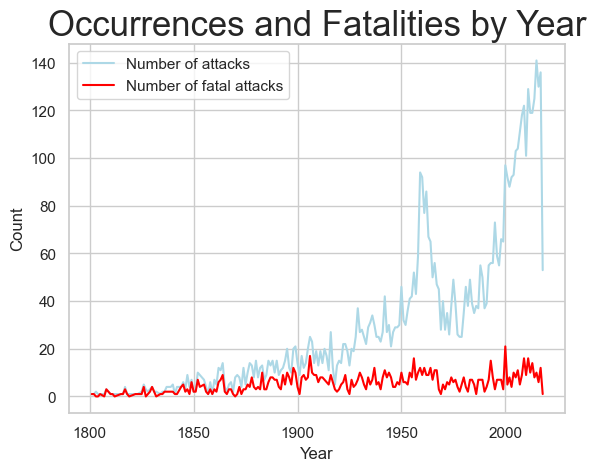

In [24]:
sns.set(style="whitegrid")
sns.lineplot(data=dfh1, x="Year", y="Count", label="Number of attacks", color="lightblue")
sns.lineplot(data=dfh1, x="Year", y="Fatal_sum", label="Number of fatal attacks", color="red")

plt.title("Occurrences and Fatalities by Year", fontsize=25)
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()

# Hipotesis 2: Países más peligrosos siglo 21

In [25]:
# Queremos ver los países con más ataques del siglo 21:
df2 = df[["Country", "Year"]]
df2 = df2[df2["Year"]>=2000]

In [26]:
# Eliminamos los valores de Country que son SEA o OCEAN ya que no son países:
df2 = df2[df2.Country.str.contains("SEA|OCEAN")==False]

In [27]:
# Agrupamos por países, y ordenamos por Year, que lo renombramos:
df2 = df2.groupby(["Country"], as_index=False).count().sort_values(by="Year", ascending=False)
df2.rename(columns={"Year":"Num_Attacks_XXI"}, inplace=True)
df2.reset_index(inplace=True, drop=True)
df2



,Country,Num_Attacks_XXI
0,USA,1017
1,AUSTRALIA,396
2,SOUTH AFRICA,137
3,BRAZIL,56
4,BAHAMAS,54
...,...,...
87,NORWAY,1
88,OKINAWA,1
89,PALESTINIAN TERRITORIES,1
90,PUERTO RICO,1


In [28]:
# Nos quedamos con aquellos que tengan más de 4 ataques:
df2 = df2[df2["Num_Attacks_XXI"]>4]
df2

,Country,Num_Attacks_XXI
0,USA,1017
1,AUSTRALIA,396
2,SOUTH AFRICA,137
3,BRAZIL,56
4,BAHAMAS,54
5,NEW ZEALAND,43
6,REUNION,31
7,MEXICO,26
8,NEW CALEDONIA,26
9,EGYPT,21


In [29]:
# Creamos un nuevo dataframe con los mismos filtros, y contamos cuantos ataques fatales hay por país en el siglo 21:
dfx = df[["Country", "Year", "Fatal (Y/N)"]]
dfx = dfx[(dfx["Fatal (Y/N)"]=="Y")&(dfx["Year"]>=2000)]
dfx = dfx.groupby(["Country"], as_index=False).count()
dfx.drop("Year", axis=1)

,Country,Fatal (Y/N)
0,ARUBA,1
1,AUSTRALIA,41
2,BAHAMAS,2
3,BELIZE,1
4,BRAZIL,17
5,COMOROS,1
6,COSTA RICA,2
7,CUBA,1
8,DIEGO GARCIA,1
9,DOMINICAN REPUBLIC,1


In [30]:
# hacemos un left join de los 2 dataframes para tener el número de ataques fatales de los países cn más ataques del siglo 21 con más de 5 ataques:

left_merged_df = pd.merge(df2, dfx, how="left", on= ["Country"])
left_merged_df.drop(["Year"], axis=1, inplace=True)
left_merged_df


,Country,Num_Attacks_XXI,Fatal (Y/N)
0,USA,1017,23.0
1,AUSTRALIA,396,41.0
2,SOUTH AFRICA,137,22.0
3,BRAZIL,56,17.0
4,BAHAMAS,54,2.0
5,NEW ZEALAND,43,5.0
6,REUNION,31,11.0
7,MEXICO,26,3.0
8,NEW CALEDONIA,26,7.0
9,EGYPT,21,6.0


In [31]:
left_merged_df["Fatal (Y/N)"] = left_merged_df["Fatal (Y/N)"].fillna(0)
left_merged_df

,Country,Num_Attacks_XXI,Fatal (Y/N)
0,USA,1017,23.0
1,AUSTRALIA,396,41.0
2,SOUTH AFRICA,137,22.0
3,BRAZIL,56,17.0
4,BAHAMAS,54,2.0
5,NEW ZEALAND,43,5.0
6,REUNION,31,11.0
7,MEXICO,26,3.0
8,NEW CALEDONIA,26,7.0
9,EGYPT,21,6.0


In [32]:
left_merged_df["Fatal (Y/N)"] = left_merged_df["Fatal (Y/N)"].astype("int")

In [33]:
left_merged_df["Fatal_Ratio"] = left_merged_df.apply(lambda row: row["Fatal (Y/N)"]/row["Num_Attacks_XXI"]*100, axis=1)

In [34]:
left_merged_df = left_merged_df.sort_values(by=["Num_Attacks_XXI", "Fatal (Y/N)"], ascending=[False, False])

In [35]:
left_merged_df.reset_index(drop=True)

,Country,Num_Attacks_XXI,Fatal (Y/N),Fatal_Ratio
0,USA,1017,23,2.261554
1,AUSTRALIA,396,41,10.353535
2,SOUTH AFRICA,137,22,16.058394
3,BRAZIL,56,17,30.357143
4,BAHAMAS,54,2,3.703704
5,NEW ZEALAND,43,5,11.627907
6,REUNION,31,11,35.483871
7,NEW CALEDONIA,26,7,26.923077
8,MEXICO,26,3,11.538462
9,EGYPT,21,6,28.571429


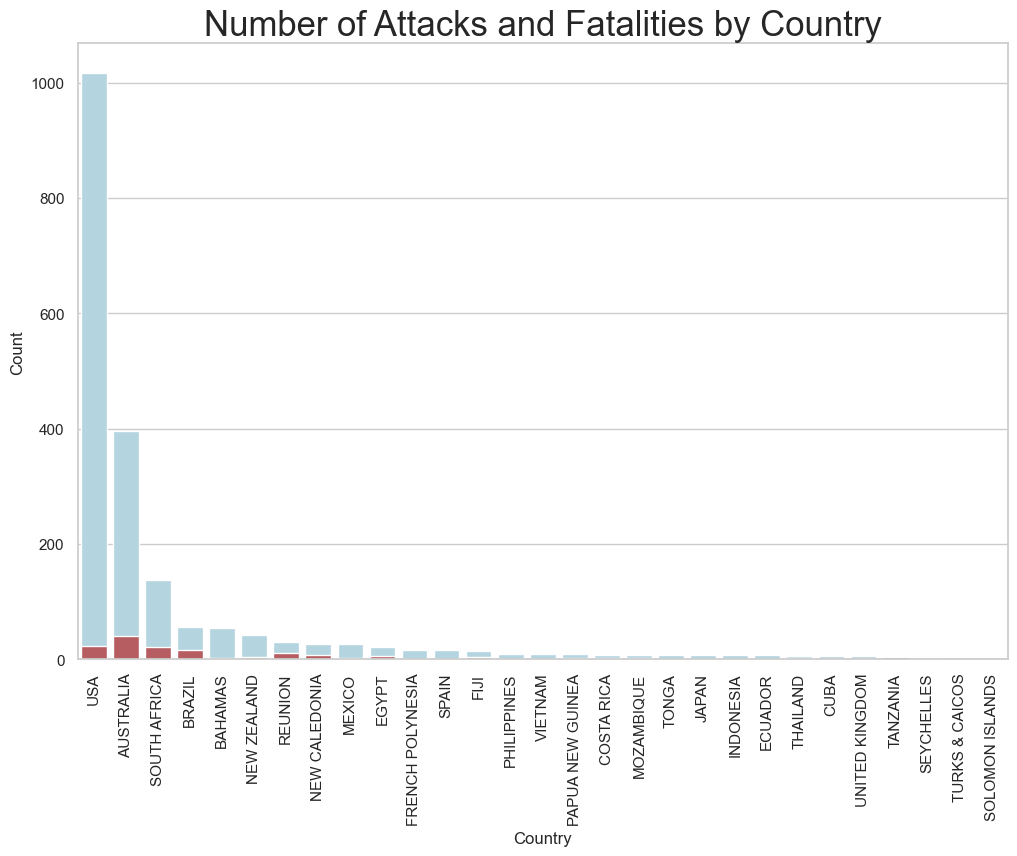

In [36]:
sns.set(style="whitegrid")
plt.figure(figsize=(12,8))

sns.barplot(data=left_merged_df, x="Country", y="Num_Attacks_XXI", color="lightblue")
sns.barplot(data=left_merged_df, x="Country", y="Fatal (Y/N)", color="r")

plt.title("Number of Attacks and Fatalities by Country", fontsize=25)
plt.xlabel("Country")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

In [37]:
country_fatal_ratio = left_merged_df[["Country", "Fatal_Ratio"]].sort_values(by="Fatal_Ratio", ascending=False)


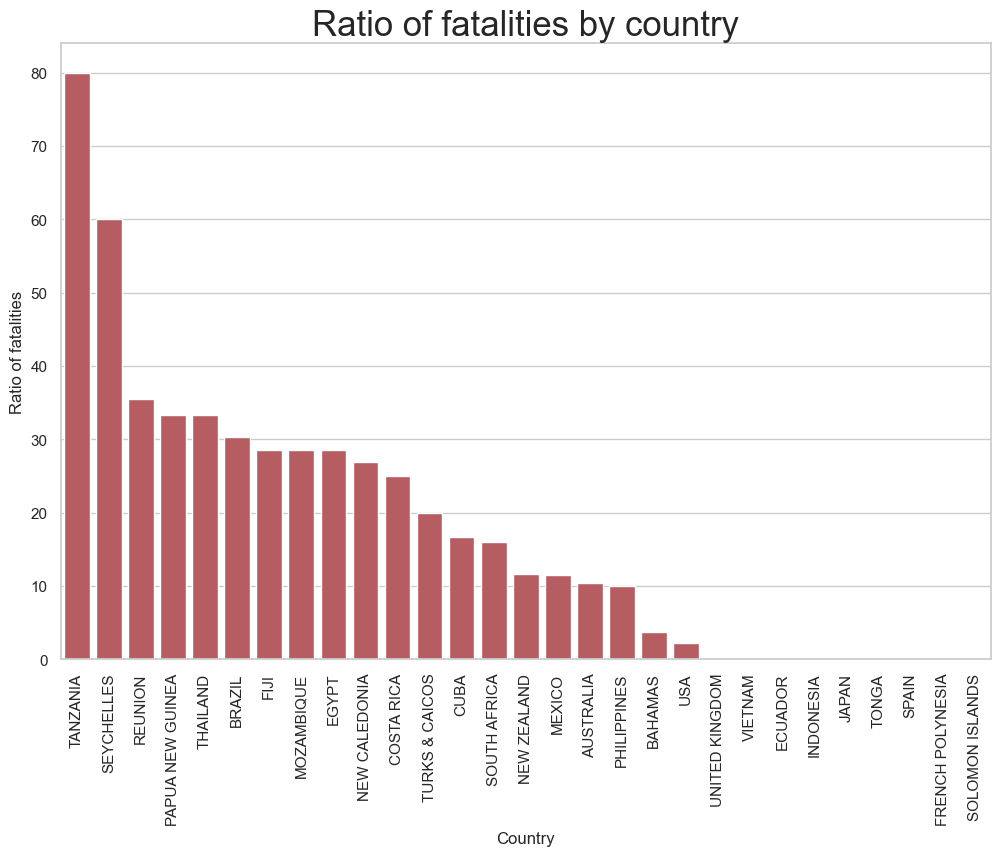

In [38]:
sns.set(style="whitegrid")
plt.figure(figsize=(12,8))

sns.barplot(data=country_fatal_ratio, x="Country", y="Fatal_Ratio", color="r")

plt.title("Ratio of fatalities by country", fontsize=25)
plt.xlabel("Country")
plt.ylabel("Ratio of fatalities")
plt.xticks(rotation=90)
plt.show()

importamos un dataframe del mundo con geopandas

In [39]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

Pasamos ambos dataframes a mayúsculas

In [40]:
left_merged_df["Country"] = left_merged_df["Country"].str.strip().str.upper()
world["name"] = world["name"].str.upper()

Creamos sets de Country y name para poder ver que hay en left_merged_df que no aparece en world dataframe

In [41]:
list1 = set(left_merged_df.Country.unique())

In [42]:
list2 = set(world.name.unique())

In [43]:
country_diff = list1 - list2

In [44]:
print(country_diff)

{'TONGA', 'SEYCHELLES', 'FRENCH POLYNESIA', 'USA', 'TURKS & CAICOS', 'REUNION', 'SOLOMON ISLANDS'}


In [45]:
list2_sorted = sorted(list2)
print(list2_sorted)

['AFGHANISTAN', 'ALBANIA', 'ALGERIA', 'ANGOLA', 'ANTARCTICA', 'ARGENTINA', 'ARMENIA', 'AUSTRALIA', 'AUSTRIA', 'AZERBAIJAN', 'BAHAMAS', 'BANGLADESH', 'BELARUS', 'BELGIUM', 'BELIZE', 'BENIN', 'BHUTAN', 'BOLIVIA', 'BOSNIA AND HERZ.', 'BOTSWANA', 'BRAZIL', 'BRUNEI', 'BULGARIA', 'BURKINA FASO', 'BURUNDI', 'CAMBODIA', 'CAMEROON', 'CANADA', 'CENTRAL AFRICAN REP.', 'CHAD', 'CHILE', 'CHINA', 'COLOMBIA', 'CONGO', 'COSTA RICA', 'CROATIA', 'CUBA', 'CYPRUS', 'CZECHIA', "CÔTE D'IVOIRE", 'DEM. REP. CONGO', 'DENMARK', 'DJIBOUTI', 'DOMINICAN REP.', 'ECUADOR', 'EGYPT', 'EL SALVADOR', 'EQ. GUINEA', 'ERITREA', 'ESTONIA', 'ESWATINI', 'ETHIOPIA', 'FALKLAND IS.', 'FIJI', 'FINLAND', 'FR. S. ANTARCTIC LANDS', 'FRANCE', 'GABON', 'GAMBIA', 'GEORGIA', 'GERMANY', 'GHANA', 'GREECE', 'GREENLAND', 'GUATEMALA', 'GUINEA', 'GUINEA-BISSAU', 'GUYANA', 'HAITI', 'HONDURAS', 'HUNGARY', 'ICELAND', 'INDIA', 'INDONESIA', 'IRAN', 'IRAQ', 'IRELAND', 'ISRAEL', 'ITALY', 'JAMAICA', 'JAPAN', 'JORDAN', 'KAZAKHSTAN', 'KENYA', 'KOSOVO',

In [46]:
replace_dict ={
    "REUNION": "MADAGASCAR", # No aparece REUNION ni MAURICIO, lo más cercano es MADAGASCAR
    "TONGA": "FIJI", # No aparece TONGA, lo más cercano es FIJI
    "FRENCH POLYNESIA": "FIJI", # No aparece FRENCH POLYNESIA, lo más cercano es FIJI
    "USA": "UNITED STATES OF AMERICA",
    "TURKS & CAICOS": "HAITI", # No aparece TURKS & CAICOS, lo más cercano es HAITI
    "SEYCHELLES": "SOMALIA", # No aparece SEYCHELLES, lo más cercano es SOMALIA
    "SOLOMON ISLANDS": "SOLOMON IS.",
    }

In [47]:
mapdf = left_merged_df

In [48]:
mapdf.Country = mapdf.Country.replace(replace_dict)

In [49]:
world = world.rename(columns={"name": "Country"})
merged = pd.merge(world, mapdf, on="Country", how="left")

In [50]:
merged["Num_Attacks_XXI"] = merged["Num_Attacks_XXI"].fillna(1)
merged["Fatal (Y/N)"] = merged["Fatal (Y/N)"].fillna(0)

In [51]:
merged.plot(column="Fatal_Ratio", scheme="quantiles",
           figsize=(250, 200),
           legend=True,cmap='Reds')
plt.title("Number of Fatalities by country",fontsize=25)
sns.set(style="whitegrid")

# Hipotesis 3: Especies de tiburones más peligrosas

In [52]:
dfh3 = df[["Country", "Fatal (Y/N)", "Species"]]

In [53]:
dfh3.Species.unique().tolist()

['White shark',
 nan,
 '2 m shark',
 'Tiger shark, 3m',
 'Tiger shark',
 "Lemon shark, 3'",
 "Bull shark, 6'",
 'Grey reef shark',
 'Invalid incident',
 'Tawny nurse shark, 2m',
 'Shark involvement not confirmed',
 'Questionable',
 '3 m shark',
 'White shark, 3.5 m',
 'White shark, 2.5 m',
 "6' shark",
 'Juvenile bull shark',
 'Bull shark',
 "Tiger shark, 12'",
 'Wobbegong shark',
 '3.5 m shark',
 '1.8 m shark',
 'Blacktip shark',
 'Juvenile white shark,  2.7 to 3.2 m',
 'Bull shark, 2 m',
 'Possibly a wobbegong',
 'Injury believed caused by an eel, not a shark',
 'Galapagos shark?',
 '2m shark',
 'Bull shark, 3 m',
 'Grey reef shark. 2 m',
 'small shark',
 'Wobbegong shark?',
 'Juvenile nurse shark',
 "Nurse shark. 5'",
 'Tiger shark, female',
 'Some drowned but other may have been killed by blue sharks',
 'White shark, 4.6 m',
 'Cookiecutter shark',
 'Wobbegong shark, 1 m',
 'White shark, 4.5 m',
 'Spinner shark, 4 to 5 feet',
 'Tiger shark, 8 to 10 feet',
 "8' shark",
 'Death may ha

In [54]:
dfh3.Species = dfh3.Species.str.upper()

/var/folders/cg/d0ycw3dj0s35gf2j2s06p71c0000gn/T/ipykernel_8598/4146843997.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfh3.Species = dfh3.Species.str.upper()


In [55]:
dfh3.Species = dfh3.Species.fillna("unknown")

/var/folders/cg/d0ycw3dj0s35gf2j2s06p71c0000gn/T/ipykernel_8598/2747898951.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfh3.Species = dfh3.Species.fillna("unknown")


In [56]:
dfh3.Species.unique().tolist()

['WHITE SHARK',
 'unknown',
 '2 M SHARK',
 'TIGER SHARK, 3M',
 'TIGER SHARK',
 "LEMON SHARK, 3'",
 "BULL SHARK, 6'",
 'GREY REEF SHARK',
 'INVALID INCIDENT',
 'TAWNY NURSE SHARK, 2M',
 'SHARK INVOLVEMENT NOT CONFIRMED',
 'QUESTIONABLE',
 '3 M SHARK',
 'WHITE SHARK, 3.5 M',
 'WHITE SHARK, 2.5 M',
 "6' SHARK",
 'JUVENILE BULL SHARK',
 'BULL SHARK',
 "TIGER SHARK, 12'",
 'WOBBEGONG SHARK',
 '3.5 M SHARK',
 '1.8 M SHARK',
 'BLACKTIP SHARK',
 'JUVENILE WHITE SHARK,  2.7 TO 3.2 M',
 'BULL SHARK, 2 M',
 'POSSIBLY A WOBBEGONG',
 'INJURY BELIEVED CAUSED BY AN EEL, NOT A SHARK',
 'GALAPAGOS SHARK?',
 '2M SHARK',
 'BULL SHARK, 3 M',
 'GREY REEF SHARK. 2 M',
 'SMALL SHARK',
 'WOBBEGONG SHARK?',
 'JUVENILE NURSE SHARK',
 "NURSE SHARK. 5'",
 'TIGER SHARK, FEMALE',
 'SOME DROWNED BUT OTHER MAY HAVE BEEN KILLED BY BLUE SHARKS',
 'WHITE SHARK, 4.6 M',
 'COOKIECUTTER SHARK',
 'WOBBEGONG SHARK, 1 M',
 'WHITE SHARK, 4.5 M',
 'SPINNER SHARK, 4 TO 5 FEET',
 'TIGER SHARK, 8 TO 10 FEET',
 "8' SHARK",
 'DEATH 

In [57]:
sharks_list = ["SANDBAR", "COW", "NURSE", "SEVEN-GILL", "SPINNER", "BLUE", "PORBEAGLE", "COOKIECUTTER", "CARIBBEAN", "BROADNOSE SEVENGILL", "REEF", "TIGER", "LEMON", "SILVERTIP", "BLACK-TIPPED", "WHITE", "BULL", "GREY", "ANGEL", "DOGFISH", "WOBBEGONG", "GUITARFISH", "RAGGEDTOOTH", "BRONZE WHALER", "HAMMERHEAD", "SILKY", "GOBLIN", "JUVENILE", "GALAPAGOS", "MAKO"]
print(sorted(sharks_list))

['ANGEL', 'BLACK-TIPPED', 'BLUE', 'BROADNOSE SEVENGILL', 'BRONZE WHALER', 'BULL', 'CARIBBEAN', 'COOKIECUTTER', 'COW', 'DOGFISH', 'GALAPAGOS', 'GOBLIN', 'GREY', 'GUITARFISH', 'HAMMERHEAD', 'JUVENILE', 'LEMON', 'MAKO', 'NURSE', 'PORBEAGLE', 'RAGGEDTOOTH', 'REEF', 'SANDBAR', 'SEVEN-GILL', 'SILKY', 'SILVERTIP', 'SPINNER', 'TIGER', 'WHITE', 'WOBBEGONG']


In [58]:
for index, row in dfh3.iterrows():
    found_shark = False
    for x in sharks_list:
        if x in row["Species"]:
            dfh3.at[index, "Species"] = x + " SHARK"
            found_shark = True
            break
    if not found_shark:
            dfh3.at[index, "Species"] = "UNKNOWN"

In [59]:
dfh3.Species.unique().tolist()

['WHITE SHARK',
 'UNKNOWN',
 'TIGER SHARK',
 'LEMON SHARK',
 'BULL SHARK',
 'REEF SHARK',
 'NURSE SHARK',
 'WOBBEGONG SHARK',
 'GALAPAGOS SHARK',
 'BLUE SHARK',
 'COOKIECUTTER SHARK',
 'SPINNER SHARK',
 'PORBEAGLE SHARK',
 'JUVENILE SHARK',
 'SEVEN-GILL SHARK',
 'CARIBBEAN SHARK',
 'BROADNOSE SEVENGILL SHARK',
 'ANGEL SHARK',
 'DOGFISH SHARK',
 'MAKO SHARK',
 'BRONZE WHALER SHARK',
 'SILKY SHARK',
 'HAMMERHEAD SHARK',
 'RAGGEDTOOTH SHARK',
 'GOBLIN SHARK',
 'SANDBAR SHARK',
 'COW SHARK',
 'GREY SHARK',
 'SILVERTIP SHARK',
 'BLACK-TIPPED SHARK',
 'GUITARFISH SHARK']

In [60]:
dfh3.loc[df["Fatal (Y/N)"]=="Y", "Fatal (Y/N)"] = 1
dfh3.loc[df["Fatal (Y/N)"]=="N", "Fatal (Y/N)"] = 0

/var/folders/cg/d0ycw3dj0s35gf2j2s06p71c0000gn/T/ipykernel_8598/1476471789.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfh3.loc[df["Fatal (Y/N)"]=="Y", "Fatal (Y/N)"] = 1
/var/folders/cg/d0ycw3dj0s35gf2j2s06p71c0000gn/T/ipykernel_8598/1476471789.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfh3.loc[df["Fatal (Y/N)"]=="N", "Fatal (Y/N)"] = 0


In [61]:
dfh3 = dfh3.dropna(subset=["Fatal (Y/N)"])

In [62]:
dfh3 = dfh3[dfh3["Fatal (Y/N)"] != "UNKNOWN"]

In [63]:
species_count = dfh3.groupby(["Species"], as_index=False)["Fatal (Y/N)"].count()
species_count.rename(columns={"Fatal (Y/N)": "Num_Attacks"}, inplace=True)

In [64]:
fatal_count = dfh3.groupby(["Species"], as_index=False)["Fatal (Y/N)"].sum()
fatal_count

,Species,Fatal (Y/N)
0,ANGEL SHARK,0
1,BLACK-TIPPED SHARK,1
2,BLUE SHARK,7
3,BROADNOSE SEVENGILL SHARK,0
4,BRONZE WHALER SHARK,1
5,BULL SHARK,21
6,CARIBBEAN SHARK,0
7,COOKIECUTTER SHARK,0
8,COW SHARK,0
9,DOGFISH SHARK,0


In [65]:
mergedh3 = pd.merge(species_count, fatal_count, on="Species", how="inner")

In [66]:
mergedh3

,Species,Num_Attacks,Fatal (Y/N)
0,ANGEL SHARK,6,0
1,BLACK-TIPPED SHARK,2,1
2,BLUE SHARK,58,7
3,BROADNOSE SEVENGILL SHARK,2,0
4,BRONZE WHALER SHARK,63,1
5,BULL SHARK,170,21
6,CARIBBEAN SHARK,19,0
7,COOKIECUTTER SHARK,1,0
8,COW SHARK,2,0
9,DOGFISH SHARK,3,0


In [67]:
mergedh3["Fatal_ratio_by_species"] = mergedh3.apply(lambda row: row["Fatal (Y/N)"]/row["Num_Attacks"]*100, axis=1)

In [68]:
mergedh3 = mergedh3.sort_values(by="Fatal_ratio_by_species", ascending=False)

In [69]:
mergedh3 = mergedh3[mergedh3["Species"]!="UNKNOWN"]

In [70]:
mergedh3.reset_index(drop=True)

,Species,Num_Attacks,Fatal (Y/N),Fatal_ratio_by_species
0,BLACK-TIPPED SHARK,2,1,50.000000
1,TIGER SHARK,282,46,16.312057
2,WHITE SHARK,649,90,13.867488
3,SANDBAR SHARK,8,1,12.500000
4,BULL SHARK,170,21,12.352941
5,BLUE SHARK,58,7,12.068966
6,MAKO SHARK,53,2,3.773585
7,LEMON SHARK,37,1,2.702703
8,HAMMERHEAD SHARK,48,1,2.083333
9,BRONZE WHALER SHARK,63,1,1.587302


In [71]:
mergedh3 = mergedh3[mergedh3["Fatal (Y/N)"]>=1]

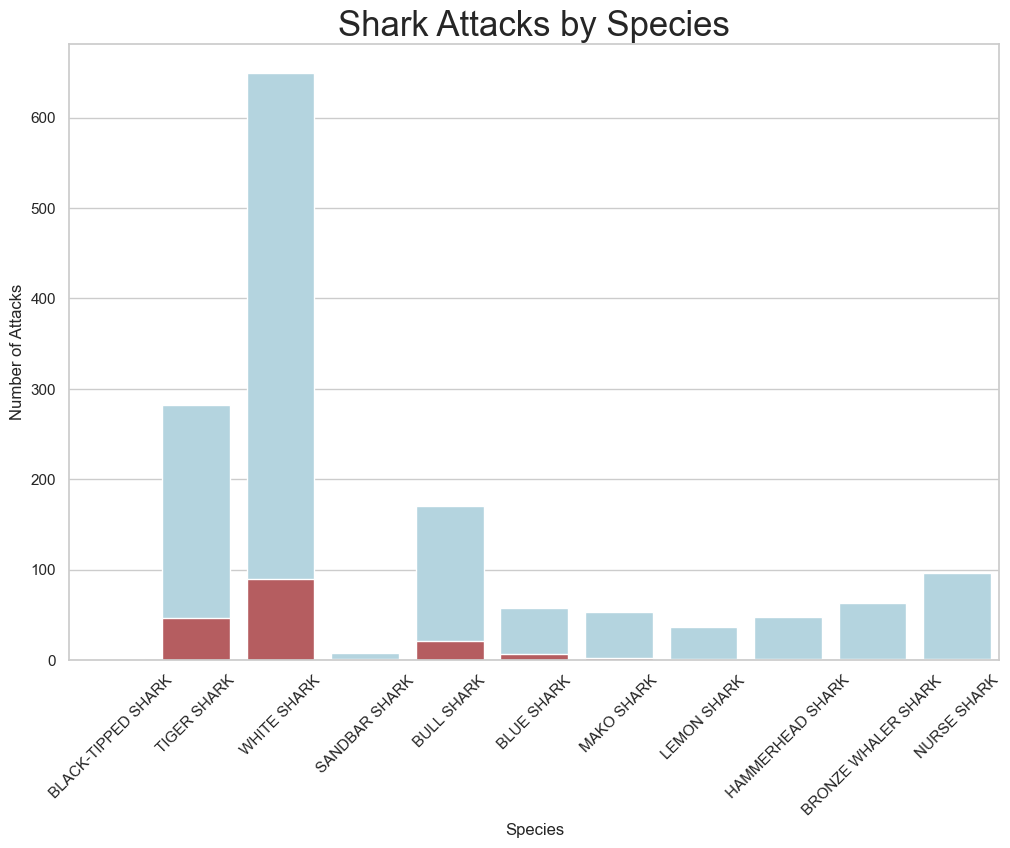

In [72]:
sns.set(style="whitegrid")
plt.figure(figsize=(12,8))

sns.barplot(x="Species", y="Num_Attacks", data=mergedh3, color="lightblue")
sns.barplot(x="Species", y="Fatal (Y/N)", data=mergedh3, color="r")

plt.title("Shark Attacks by Species", fontsize=25)
plt.ylabel("Number of Attacks")
plt.xticks(rotation=45)
plt.show()

In [73]:
shark_ratio = mergedh3[["Species", "Fatal_ratio_by_species"]]
shark_ratio.reset_index(drop=True)

,Species,Fatal_ratio_by_species
0,BLACK-TIPPED SHARK,50.000000
1,TIGER SHARK,16.312057
2,WHITE SHARK,13.867488
3,SANDBAR SHARK,12.500000
4,BULL SHARK,12.352941
5,BLUE SHARK,12.068966
6,MAKO SHARK,3.773585
7,LEMON SHARK,2.702703
8,HAMMERHEAD SHARK,2.083333
9,BRONZE WHALER SHARK,1.587302


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'BLACK-TIPPED SHARK'),
  Text(1, 0, 'TIGER SHARK'),
  Text(2, 0, 'WHITE SHARK'),
  Text(3, 0, 'SANDBAR SHARK'),
  Text(4, 0, 'BULL SHARK'),
  Text(5, 0, 'BLUE SHARK'),
  Text(6, 0, 'MAKO SHARK'),
  Text(7, 0, 'LEMON SHARK'),
  Text(8, 0, 'HAMMERHEAD SHARK'),
  Text(9, 0, 'BRONZE WHALER SHARK'),
  Text(10, 0, 'NURSE SHARK')])

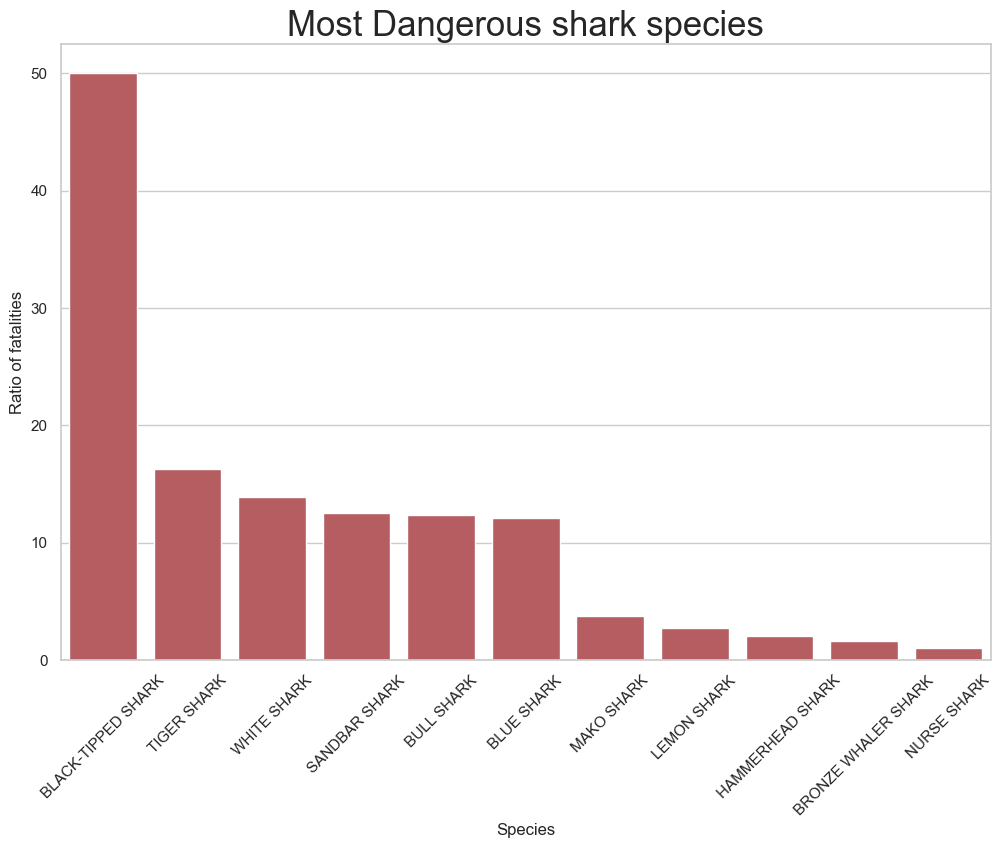

In [74]:
sns.set(style="whitegrid")
plt.figure(figsize=(12,8))

sns.barplot(x="Species", y="Fatal_ratio_by_species", data=shark_ratio, color="r")
plt.title("Most Dangerous shark species", fontsize=25)
plt.ylabel("Ratio of fatalities")
plt.xticks(rotation=45)